# Research and development of counting mosquito eggs

## Import libraries

The main libraries/packages that we use is opencv-python and numpy.
We use python 3.7

In [1]:
import pip

for package in ['opencv-python==4.4.0.46', 'numpy==1.19.3', 'matplotlib.pyplot', 'ipywidgets']:
    try:
        __import__(package)
    except ImportError:
        pip.main(['install', package])

import cv2
from ipywidgets import interact as widgets
from matplotlib import pyplot as plt
import numpy as np

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


## Methodology

### Foreground extraction 

The foreground is defined as the part of the image that contains the eggs. We use the foreground extraction function to adjust image contrast and brightness, using Otsu's method to thresholding images and finally overlaying the found eggs. 

In [2]:
def plotimages(img1, img2, img1_title, img2_title):
    NUM_ROWS = 1
    IMGs_IN_ROW = 2
    f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(16, 6))

    ax[0].imshow(img1)
    ax[1].imshow(img2)

    ax[0].set_title(img1_title)
    ax[1].set_title(img2_title)

    title = 'Side by side view of images'
    f.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    
def plotimage(img1,img1_title):
    f, ax = plt.subplots(1, 1, figsize=(16, 6))

    ax[0].imshow(img1)
    ax[0].set_title(img1_title)
   
    title = 'Image'
    f.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def foreground_extraction(img_title, is_reduce_noise, in_noise_area, out_noise_area):
    # OTSU###################################################################

    # Read the image in a greyscale mode
    ori_image = cv2.imread(img_title)

    top, bottom, left, right = [2] * 4
    ori_image_border = cv2.copyMakeBorder(ori_image, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                          value=[255, 255, 255])

    load_image = cv2.cvtColor(ori_image_border, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce image noise if it is required
    if is_reduce_noise:
        image = cv2.GaussianBlur(load_image, (5, 5), 0)
        otsu_threshold, otsu_result = cv2.threshold(
            image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU, )
    else:
        otsu_threshold, otsu_result = cv2.threshold(
            load_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU, )

    # copy image
    img = otsu_result.copy()
    ret, thresh = cv2.threshold(img, 127, 255, 0, cv2.THRESH_BINARY)
    thresh = 255 - thresh
    # Use cv2.CCOMP for two level hierarchy
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # loop through the contours
    for i, cnt in enumerate(contours):
        # if the contour has no other contours inside of it
        if hierarchy[0][i][3] != -1:  # basically look for holes
            # if the size of the contour is less than a threshold (noise)
            if cv2.contourArea(cnt) < in_noise_area:
                # Fill the holes in the original image
                cv2.drawContours(img, [cnt], 0, [255, 255, 255], -1)

    # Creating the noise mask
    image1 = (otsu_result - img)
    cv2.floodFill(image1, None, (0, 0), (255, 255, 255))

    bit_and = cv2.bitwise_and(otsu_result, image1)

    ########################################################################
    # REMOVING AND IDENTIFYING NOISE OUTSIDE
    dirt_image = bit_and.copy()

    ret, thresh = cv2.threshold(dirt_image, 127, 255, 0, cv2.THRESH_BINARY)
    # Use cv2.CCOMP for two level hierarchy
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    for i, cnt in enumerate(contours):
        # if the contour has no other contours inside of it
        if hierarchy[0][i][3] != -1:  # basically look for holes
            # if the size of the contour is less than a threshold (noise)
            if cv2.contourArea(cnt) < out_noise_area:
                # Fill the holes in the original image
                cv2.drawContours(thresh, [cnt], 0, [255, 255, 255], -1)
    # Visualize the image after the Otsu's method application

    cv2.imwrite("Clean_image.png", thresh)
    
    #converting BGR2RGB
    rgb_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)
    rgb_thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB)

    plotimages(img1=rgb_image,
               img2=rgb_thresh,
               img1_title='Original Image',
               img2_title='Processed Image')

widgets(foreground_extraction, img_title="All_eggs.jpg",
         is_reduce_noise=False,
         in_noise_area=(0, 240, 1),
         out_noise_area=(0, 2000, 1));

# Try in_noise_area = 120
# Try out_noise_area = 700



interactive(children=(Text(value='All_eggs.jpg', description='img_title'), Checkbox(value=False, description='…

## Eggs Sorter

### We would like to sort images by cluster type. There are three cluster types that we sort:

- Single eggs: 1 egg
- Small cluster: Groups of 2-3 eggs
- Large cluster: Groups of 4 or more eggs 

#### Counting the average number of single eggs 


In [3]:
red   = [60, 20, 220]
magenta = [255,0,255]
blue  = [255,191,0]
white = [255,255,255]
black = [0,0,0]

def sort_eggs(img_title, max_egg_area, min_egg_area, single = True):
    ori_image = cv2.imread(img_title)
    
    img = cv2.imread(img_title, 0)
    ret, thresh = cv2.threshold(img, 127, 255, 0, cv2.THRESH_BINARY)

    # Find contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a mask which will have the eggs
    mask = np.full((img.shape[0], img.shape[1]), 0, dtype=np.uint8)
    bgr_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    #######################################################################################################################################
    #Single Clusters#######################################################################################################################
    #BLUE###############################################################################################################################
    
    if single:
        for i, cnt in enumerate(contours):
        # Grabbing the contours that fits in the criteria
           if cv2.contourArea(cnt) > min_egg_area and cv2.contourArea(cnt) < max_egg_area:
                cv2.drawContours(bgr_mask, [cnt], 0, blue, -1)
                
     #######################################################################################################################################
    #Small Clusters#######################################################################################################################
    #PURPLE/Magenta###############################################################################################################################
             
        for i, cnt in enumerate(contours):
        # if the contour has no other contours inside of it
           if cv2.contourArea(cnt) > max_egg_area and cv2.contourArea(cnt) < min_egg_area*8:
                cv2.drawContours(bgr_mask, [cnt], 0, magenta, -1)            
                
    else:
        bgr_mask

    #######################################################################################################################################
    #Big Clusters#####################################################################################################################
    ##Red/Crimson############################################################################################################################
    for i, cnt in enumerate(contours):
        # if the contour has no other contours inside of it
        if cv2.contourArea(cnt) > min_egg_area*8 and cv2.contourArea(cnt) < max_egg_area*1000:
            cv2.drawContours(bgr_mask, [cnt], 0, red, -1)

    #######################################################################################################################################
    #Getting Holes#############################################################################################################
    #######################################################################################################################################
    # Colored and sorted eggs to be stored in bgrmask

    # Create a mask which will have the eggs
    for i, cnt in enumerate(contours):
        if hierarchy[0, i, 3] == -1:
            if cv2.contourArea(cnt) < 100000:
                cv2.drawContours(bgr_mask, contours, i, (0, 0, 0), -1)
                if hierarchy[0, i, 2] != -1:  # if this contour has inner contours
                    childrenIndex = hierarchy[0, i, 2]
                    while hierarchy[0, childrenIndex, 0] != -1:  # get all children for the outer contour
                        childrenIndex = hierarchy[0, childrenIndex, 0]
                        # now the first inner contour is just near the outer one (from the opposite side of the line)
                        # thats why we are drawing that inner contour's children
                        if hierarchy[0, childrenIndex, 2] != -1:
                            cv2.drawContours(bgr_mask, contours, hierarchy[0, childrenIndex, 2], (0, 0, 0), -1)
    
    rgb_mask = cv2.cvtColor(bgr_mask, cv2.COLOR_BGR2RGB)
    
    plotimages(img1=ori_image,
               img2=rgb_mask,
               img1_title='Original Image',
               img2_title='Sorted Image')

    cv2.imwrite("Sorted_eggs.png", bgr_mask)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Max_egg_area = 7000, min_egg_area = 3000, trying to get average egg count
widgets(sort_eggs, 
         img_title = "Clean_image.png", 
         min_egg_area = 1000, 
         max_egg_area = 1800, 
         single = True);


interactive(children=(Text(value='Clean_image.png', description='img_title'), IntSlider(value=1800, descriptio…

## Counting average size of eggs
Get mask for single eggs 
Process and count average size 
Store average size

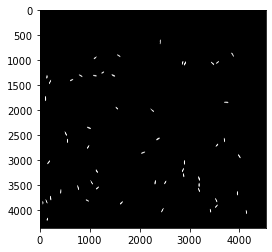

The number of single egg: 54
The average egg size: 1458.8796296296296
These eggs have been removed


In [4]:
def counting_single_eggs(img_to_count):
    img = cv2.imread("Sorted_eggs.png")
    # Make mask of all perfectly red pixels
    Rmask = np.all(img == blue, axis=-1)

    # Make all non-red pixels black
    img[~Rmask] = black

    # Convert egg color to white
    img[np.where((img == blue).all(axis=2))] = white

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 50, 200)

    contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    egg_count = len(contours)

    areas = []
    for i, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        areas.append(area)
        a = sum(areas)
        average_egg = a / egg_count
    
    plt.figure()
    plt.imshow(img) 
    plt.show() # display it
    
    #Print results
    print("The number of single egg:", str(egg_count))
    print("The average egg size:", str(average_egg))
    print("These eggs have been removed")
    
counting_single_eggs("Sorted_eggs.png")

### Counting large clusters

Area of interest are large clusters of the red colored eggs

## Before you run this, you will need to untick the "single" box above.

In [7]:
def get_egg_foregroud (original_img, threshold_img):
    #read images
    img1 = cv2.imread(original_img)
    img2 = cv2.imread(threshold_img)

    #Convert egg color to white
    img2[np.where((img2 == red).all(axis=2))] = [255, 255, 255]
    
    #Turn eggs Black
    img2 = 255 - img2
    cv2.imwrite("Large_cluster_mask.png", img2)
    #adding a small boarder to match previous code
    color = [255, 255, 255]  # cause white!
    top, bottom, left, right = [2] * 4
    img1 = cv2.copyMakeBorder(img1, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    #bit image
    bit_or = cv2.bitwise_or(img1, img2)

    #show and write results
    cv2.imwrite("Eggs_foreground.png", bit_or)
    
    rgb_image = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    plotimages(img1=rgb_image,
               img2=bit_or,
               img1_title='Original Image',
               img2_title='Processed Image')
    
    
widgets(get_egg_foregroud, original_img="All_eggs.jpg",
         threshold_img = "Sorted_eggs.png"
        );


interactive(children=(Text(value='All_eggs.jpg', description='original_img'), Text(value='Sorted_eggs.png', de…